In [1]:
!pip install urllib3==1.26.16 charset_normalizer==2.0.4

In [2]:
# For data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageEnhance

# For machine learning
import tensorflow as tf
from keras.losses import *
from keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense

# For Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.style as style
style.use('ggplot')

# Misellaneous
from tqdm import tqdm
import os
import random

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\requests\__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Found 5712 images in 4 labels.

The first 5 images in the training set are:
['meningioma', 'pituitary', 'pituitary', 'meningioma', 'glioma']


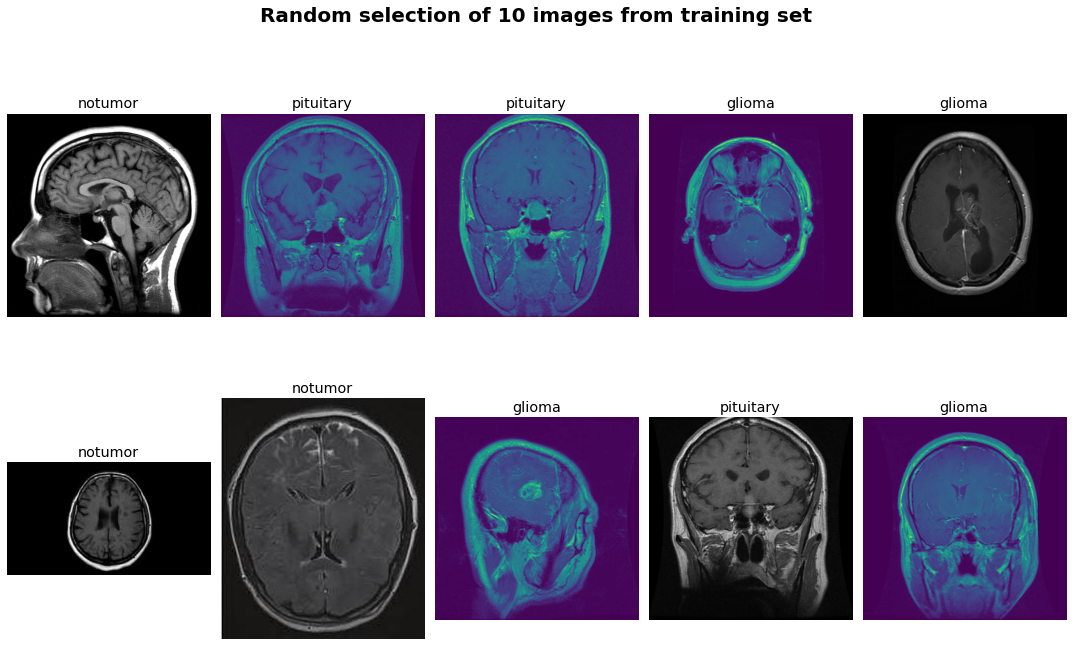

In [3]:
# Define the relative paths
relative_path_train=os.path.join('brain-tumor-mri-dataset', 'Training')
relative_path_test=os.path.join('brain-tumor-mri-dataset', 'Testing')

# Get the base directory of the current script
base_dir=os.path.dirname(os.path.abspath(r'C:\Users\Admin\Downloads\brain-tumor-mri-dataset'))
train_dir=os.path.join(base_dir, relative_path_train)
test_dir=os.path.join(base_dir, relative_path_test)

# Initialize lists to store image paths and labels
train_paths=[]
train_labels=[]

# Ensure the training directory exists
if not os.path.exists(train_dir):
  print(f"Training path does not exist: {train_dir}")
else:
  # Traverse subdirectories and files within the training directory
    for label in os.listdir(train_dir):
      label_path=os.path.join(train_dir, label)
      if os.path.isdir(label_path):
        for image in os.listdir(label_path):
          image_path=os.path.join(label_path, image)
          if os.path.isfile(image_path):
            train_paths.append(image_path)
            train_labels.append(label)
    # Shuffle the data
    train_paths, train_labels=shuffle(train_paths, train_labels)
    print(f"Found {len(train_paths)} images in {len(set(train_labels))} labels.")
    num_train_labels=5
    print(f'\nThe first {num_train_labels} images in the training set are:\n{train_labels[:num_train_labels]}')
    # Randomly select 10 images
    sample_indices=random.sample(range(len(train_paths)), 10)
    sample_paths=[train_paths[i] for i in sample_indices]
    sample_labels=[train_labels[i] for i in sample_indices]
    # Display the images and their labels
    plt.figure(figsize=(15, 10))
    for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
        img=mpimg.imread(path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.suptitle('Random selection of 10 images from training set',fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()

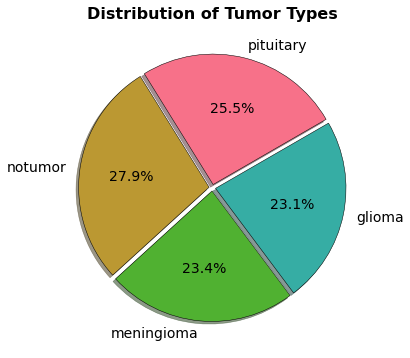

In [4]:
# Example data for labels and counts
labels=['pituitary', 'notumor', 'meningioma', 'glioma']
counts=[
len([x for x in train_labels if x == 'pituitary']),
len([x for x in train_labels if x == 'notumor']),
len([x for x in train_labels if x == 'meningioma']),
len([x for x in train_labels if x == 'glioma'])
]
# Setting Seaborn color palette
sns.set_palette("husl")
# Setting up the figure and size
plt.figure(figsize=(14, 6))

plt.rcParams.update({'font.size': 14})
# Pie chart using Seaborn
plt.pie(counts,labels=labels,autopct='%.1f%%',startangle=30,wedgeprops={'edgecolor': 'black'}, # Adding black edges to wedges
        explode=(0.025, 0.025, 0.025, 0.025), # Exploding the wedges
        shadow=True) # Adding shadows to wedges
# Title of the chart
plt.title('Distribution of Tumor Types', fontsize=16, fontweight='bold')
# Displaying the chart
plt.show()

In [5]:
test_paths=[]
test_labels=[]
for label in os.listdir(test_dir):
    label_path=os.path.join(test_dir, label)
    if os.path.isdir(label_path):
        for image in os.listdir(label_path):
            image_path=os.path.join(label_path, image)
            if os.path.isfile(image_path):
                test_paths.append(image_path)
                test_labels.append(label)
# Shuffle the data
test_paths, test_labels=shuffle(test_paths, test_labels)
num_test_labels=5
print(f'\nThe first {num_test_labels} images in the Testing set are:\n{test_labels[:num_test_labels]}')


The first 5 images in the Testing set are:
['glioma', 'notumor', 'pituitary', 'notumor', 'pituitary']


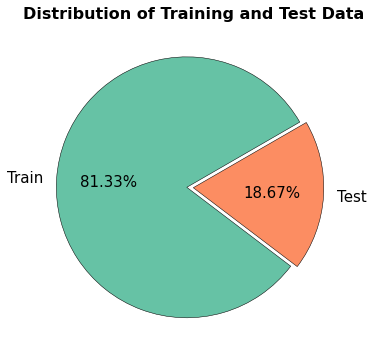

In [6]:
# Seatting Seaborn color palette
colors=sns.color_palette('Set2') # Selecting a Seaborn color palette
sns.set_palette(colors)

# Setting up the figure and size
plt.figure(figsize=(14, 6))
plt.rcParams.update({'font.size':15})

# Pie chart
plt.pie([len(train_labels), len(test_labels)],labels=['Train', 'Test'],autopct='%.2f%%',explode=(0.05, 0),startangle=30, 
        wedgeprops={'edgecolor':'black'}, # Adding black edges to the wedgesshadow=True
       ) # True shadows to the wedges
        
# Title of the chart
plt.title('Distribution of Training and Test Data', fontsize=16, fontweight='bold')
plt.show()

In [7]:
def augment_image(image):
    image=Image.fromarray(np.uint8(image))
    image=ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image=ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image=np.array(image)/255.0
    return image

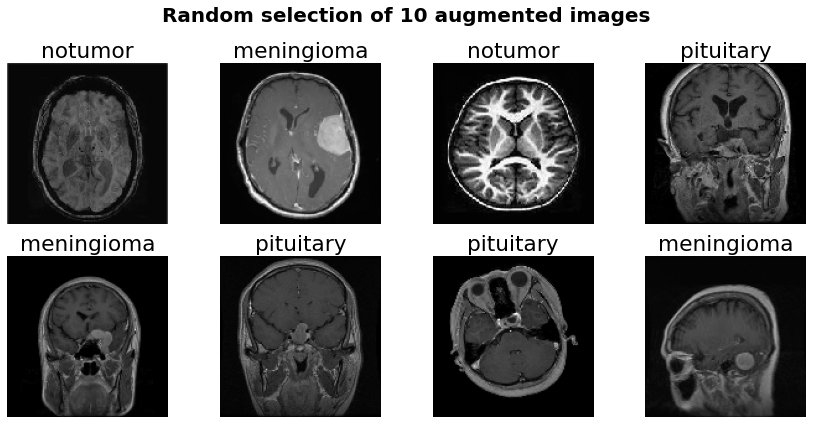

In [8]:
# Set the image size
IMAGE_SIZE = 130

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the
    images as arrays (after augmenting them).
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)  # Assuming `augment_image` is defined elsewhere
        images.append(image)
    return np.array(images)

# Load a subset of images
images = open_images(train_paths[50:59])
labels = train_paths[50:59]

# Set up the figure
fig = plt.figure(figsize=(12, 6))

for x in range(8):  # Loop through the first 8 images
    fig.add_subplot(2, 4, x + 1)
    plt.axis('off')
    image_name = os.path.basename(os.path.dirname(labels[x]))
    plt.title(image_name)
    plt.imshow(images[x])
    
plt.rcParams.update({'font.size': 12})
plt.suptitle('Random selection of 10 augmented images', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
unique_labels=os.listdir(train_dir)

def encode_label(labels):
    encoded=[]
    for i in labels:
        encoded.append(unique_labels.index(i))
    return np.array(encoded)
    
def decode_label(labels):
    decoded=[]
    for i in labels:
        decoded.append(unique_labels[i])
    return np.array(decoded)
    
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths=paths[i: i+batch_size]
            batch_images=open_images(batch_paths)
            batch_labels=labels[i: i+batch_size]
            batch_labels=encode_label(batch_labels)
            yield batch_images, batch_labels

In [26]:
base_model=VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Set all the layers to non-trainable
for layer in base_model.layers:
    layer.trainable=False
# Set the last vgg block to trainable
base_model.layers[-2].trainable=True
base_model.layers[-3].trainable=True
base_model.layers[-4].trainable=True
model=Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1048704   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
Total params: 15,763,908
Trainable params: 8,128,644
Non-trainable params: 7,635,264
___________________________________

In [27]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', 
    metrics=['sparse_categorical_accuracy']
)

In [28]:
batch_size=20
steps=int(len(train_paths)/batch_size)

epochs=4
history=model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs), epochs=epochs, steps_per_epoch=steps)

Epoch 1/4
285/285 [==============================] - 1730s 6s/step - loss: 0.4470 - sparse_categorical_accuracy: 0.8363
Epoch 2/4
285/285 [==============================] - 1698s 6s/step - loss: 0.2315 - sparse_categorical_accuracy: 0.9134
Epoch 3/4
285/285 [==============================] - 1763s 6s/step - loss: 0.1548 - sparse_categorical_accuracy: 0.9413
Epoch 4/4
285/285 [==============================] - 1747s 6s/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9563


In [33]:
# Check a batch of data
for batch_images, batch_labels in datagen(train_paths[:batch_size], train_labels[:batch_size], batch_size=batch_size, epochs=1):
    print("Batch images shape:", batch_images.shape)
    print("Batch labels shape:", batch_labels.shape)
    break

Batch images shape: (32, 130, 130, 3)
Batch labels shape: (32,)


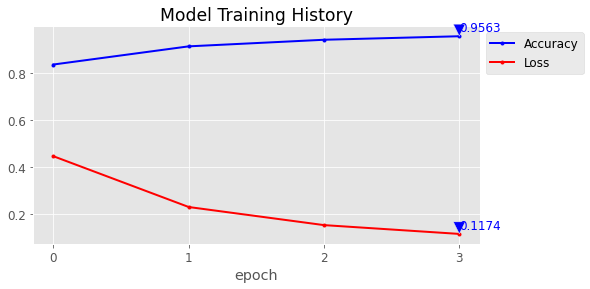

In [29]:
plt.figure(figsize=(8, 4))
plt.grid(True)
accuracy=history.history['sparse_categorical_accuracy']
loss=history.history['loss']
plt.plot(accuracy, '.b-', linewidth=2)
plt.plot(loss, '.r-', linewidth=2)
plt.annotate(f'{accuracy[-1]:.4f}', xy=(len(accuracy)-1, accuracy[-1]),xytext=(len(accuracy)-1, accuracy[-1]+0.02),arrowprops=dict(facecolor='blue', shrink=0.05),fontsize=12, color='blue')
plt.annotate(f'{loss[-1]:.4f}', xy=(len(loss)-1, loss[-1]),xytext=(len(loss)-1, loss[-1]+0.02),arrowprops=dict(facecolor='blue', shrink=0.05),fontsize=12, color='blue')
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([i for i in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc= 'upper left', bbox_to_anchor=(1,1))
plt.show()

In [30]:
batch_size=32
steps=int(len(test_paths)/batch_size)

y_pred=[]
y_true=[]

for x, y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred=model.predict(x)
    pred=np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

41it [06:49,  9.98s/it]                                                                                                


In [31]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      glioma       0.96      0.84      0.90       300
  meningioma       0.86      0.87      0.86       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.93      0.98      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



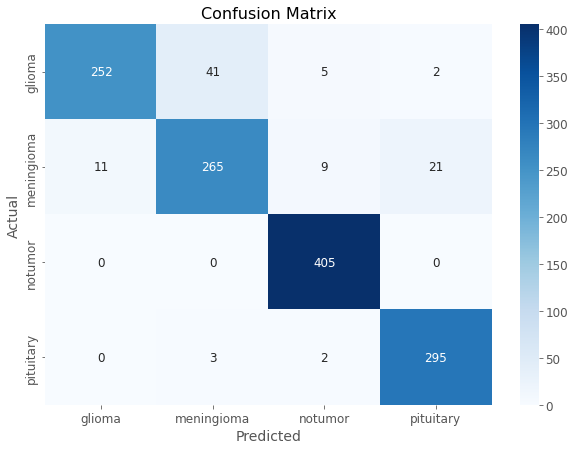

In [36]:
class_names=[name for name in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, name))]

cm=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,xticklabels=class_names, yticklabels=class_names,annot_kws={'size': 12})
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.show()

### END OF PROJECT